In [103]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

warnings.filterwarnings('ignore')

# DATA

In [104]:

train_home_team_statistics_df = pd.read_csv('train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('train_away_team_statistics_df.csv', index_col=0)


train_scores = pd.read_csv('Y_train.csv', index_col=0)


train_home = train_home_team_statistics_df.iloc[:,2:]
train_away = train_away_team_statistics_df.iloc[:,2:]

train_home.columns = [f'home_{col}' for col in train_home.columns]
train_away.columns = [f'away_{col}' for col in train_away.columns]

train = pd.concat([train_home, train_away], axis=1)
train_scores = train_scores.loc[train.index]
def func(row):
    if row[0]==1: 
        return 1
    elif row[1]==1:
        return 0
    elif row[2]==1:
        return -1
    
train_new_y = train_scores.apply(func,axis = 1)

In [105]:
# create a new dataset in which for each feature we compute the diff between the home and away team
train_diff = train_home_team_statistics_df.iloc[:,2:].sub(train_away_team_statistics_df.iloc[:,2:], fill_value=0)

In [106]:
# compute z scores on train_diff
train_diff = train_diff.apply(lambda x: (x - np.mean(x)) / np.std(x))

In [107]:
# split the data into a training and test set
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_diff, train_new_y, test_size=0.2, random_state=42)


In [108]:
# train a random forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train.fillna(0), y_train)
predictions = clf.predict(X_test.fillna(0))
print('Random Forest: ', accuracy_score(y_test, predictions))



Random Forest:  0.48110524177163755


# PCA

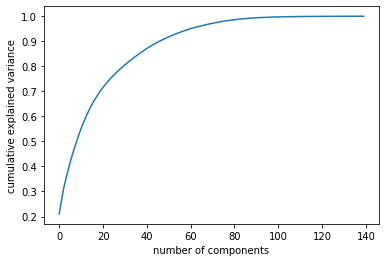

In [109]:
# PCA on X_train and variance explained
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train.fillna(0))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [110]:
# keep enough components to explain 95% of the variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.95)
pca = PCA(n_components=n_components)
pca.fit(X_train.fillna(0))
X_train_pca = pca.transform(X_train.fillna(0))
X_test_pca = pca.transform(X_test.fillna(0))


In [111]:
# fit rf on pca data
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_pca, y_train)

RandomForestClassifier(random_state=42)

In [112]:
# predict
predictions = clf.predict(X_test_pca)

# accuracy
print('Random Forest with PCA: ', accuracy_score(y_test, predictions))


Random Forest with PCA:  0.47135310849248274


In [113]:
# CV with tqdm in order to find the best number of components 
n_components = np.linspace(1,140,5).astype(int)
scores = []
for n in tqdm(n_components):
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train.fillna(0))
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    score = model_selection.cross_val_score(clf, X_train_pca, y_train, cv=5, scoring='accuracy')
    scores.append(score.mean())

100%|██████████| 5/5 [04:02<00:00, 48.55s/it]


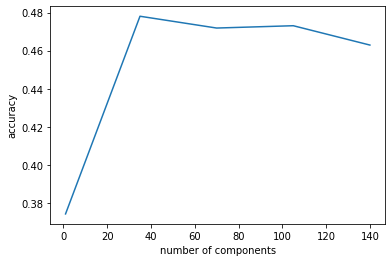

In [114]:
# plot the scores
plt.plot(n_components, scores)
plt.xlabel('number of components')
plt.ylabel('accuracy')
plt.show()


In [115]:
nb_components = n_components[np.argmax(scores)]

In [116]:
# fit the pca on the training data
pca = PCA(n_components=nb_components)
pca.fit(X_train.fillna(0))
X_train_pca = pca.transform(X_train.fillna(0))
X_test_pca = pca.transform(X_test.fillna(0))

# fit the rf on the pca data
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_pca, y_train)

# predict
predictions = clf.predict(X_test_pca)

# accuracy
print('Random Forest with PCA: ', accuracy_score(y_test, predictions))

Random Forest with PCA:  0.48354327509142625


In [117]:
# CV to check a set of hyperparameters
n_estimators = [500]
max_depth = [10]
scores = []
for n in tqdm(n_estimators):
    for d in max_depth:
        clf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=42)
        score = model_selection.cross_val_score(clf, X_train_pca, y_train, cv=5, scoring='accuracy')
        scores.append(score.mean())

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:15<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# print the best hyperparameters
print(n_estimators[np.argmax(scores)], max_depth[np.argmax(scores)])


500 10


In [78]:
# fit the rf on the training data
clf = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=42)
clf.fit(X_train_pca, y_train)

# predict
predictions = clf.predict(X_test_pca)

# accuracy
print('Random Forest with PCA: ', accuracy_score(y_test, predictions))


Random Forest with PCA:  0.49451442503047544


In [123]:
# try xgboost
clf = xgb.XGBClassifier(n_estimators=500, random_state=42)
clf.fit(X_train_pca, y_train+1)
predictions = clf.predict(X_test_pca)
print('XGBoost with PCA: ', accuracy_score(y_test+1, predictions))


XGBoost with PCA:  0.4550995530272247


# TEST and SUBMISSION

In [80]:
test_home_team_statistics_df = pd.read_csv('test_home_team_statistics_df.csv', index_col=0)
test_away_team_statistics_df = pd.read_csv('test_away_team_statistics_df.csv', index_col=0)

In [83]:
# create a new dataset in which for each feature we compute the diff between the home and away team
test_diff = test_home_team_statistics_df.sub(test_away_team_statistics_df, fill_value=0)

In [84]:
# compute z scores on train_diff
test_diff = test_diff.apply(lambda x: (x - np.mean(x)) / np.std(x))

In [85]:
test_diff_pca = pca.transform(test_diff.fillna(0))

In [91]:
# predict on the test data

y_submit = clf.predict(test_diff_pca)
y_submit = pd.DataFrame(y_submit)

y_submit.index = y_submit.index + 12303
y_submit.columns = ['result']



In [93]:

y_submit['HOME_WINS'] = y_submit['result'].apply(lambda x : 1 if x == 1 else 0)
y_submit['DRAW'] = y_submit['result'].apply(lambda x : 1 if x == 0 else 0)
y_submit['AWAY_WINS'] = y_submit['result'].apply(lambda x : 1 if x == -1 else 0)
y_submit = y_submit.drop('result',axis=1)


In [96]:
y_submit.to_csv('y_submit_27_10.csv')